In [3]:
import pandas as pd
from sqlalchemy import create_engine
# Dependencies
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from matplotlib.pyplot import figure

In [4]:
import pymysql
pymysql.install_as_MySQLdb()

### Store CSV into DataFrame

In [5]:
# The csv files for the employee reviews of companies including Google
reviews_file = "Resources/employee_reviews.csv"
customer_data_df = pd.read_csv(reviews_file)
customer_data_df.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


### Create new data with select columns

In [6]:
# Selecting only from Google employees
google_review_df=customer_data_df[customer_data_df["company"]=="google"]
print(google_review_df.shape)

# Create new data with selected columns
google_df=google_review_df[["dates","job-title", "overall-ratings"]].copy()

# Selecting only the current employees and the anonymous reviews to be objective
google_df=google_df[google_df["job-title"].str.contains("Current")]
google_df=google_df[google_df["job-title"].str.contains("Anonymous")]
print(google_df.shape)
google_df.head()

(7819, 17)
(2251, 3)


,dates,job-title,overall-ratings
0,"Dec 11, 2018",Current Employee - Anonymous Employee,5.0
3,"Feb 8, 2015",Current Employee - Anonymous Employee,5.0
8,"Dec 10, 2018",Current Employee - Anonymous Employee,5.0
9,"Dec 9, 2018",Current Employee - Anonymous Employee,5.0
10,"Dec 8, 2018",Current Employee - Anonymous Employee,5.0


In [7]:
# Convert the date format to a standard date
google_df["date"]=google_df.dates.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-01'))
google_df=google_df[["date","job-title", "overall-ratings"]].copy()
google_df.head()

,date,job-title,overall-ratings
0,2018-12-01,Current Employee - Anonymous Employee,5.0
3,2015-02-01,Current Employee - Anonymous Employee,5.0
8,2018-12-01,Current Employee - Anonymous Employee,5.0
9,2018-12-01,Current Employee - Anonymous Employee,5.0
10,2018-12-01,Current Employee - Anonymous Employee,5.0


In [8]:
google_month_df=google_df.groupby("date").mean()
google_month_df['date'] = google_month_df.index
google_month_df.index.names = ['dates']
#google_month_df.reset_index()
google_month_df.head()

,overall-ratings,date
dates,,
2008-06-01,3.25,2008-06-01
2008-07-01,5.00,2008-07-01
2008-09-01,2.00,2008-09-01
2008-10-01,4.00,2008-10-01
2009-04-01,4.00,2009-04-01


### Store CSV data into a DataFrame

In [9]:
stock_value_file = "Resources/HistoricalQuotes.csv"
stock_df = pd.read_csv(stock_value_file)
stock_df["dates"]=stock_df.date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-01'))
# Select the necessary colums only, we take closing value as reference.
stock_df=stock_df[["dates", "close"]]
stock_df.head()

,dates,close
0,2019-04-01,1222.73
1,2019-04-01,1209.59
2,2019-04-01,1206.45
3,2019-04-01,1202.69
4,2019-04-01,1208.28


In [10]:
stock_month_df=stock_df.groupby("dates").mean()
stock_month_df['date'] = stock_month_df.index
stock_month_df.head()

,close,date
dates,,
2009-04-01,194.243000,2009-04-01
2009-05-01,202.071835,2009-05-01
2009-06-01,214.072609,2009-06-01
2009-07-01,215.844095,2009-07-01
2009-08-01,231.315957,2009-08-01


### Clean DataFrame

In [11]:
data_df=pd.merge(google_month_df, stock_month_df, how='left', on="date",
         left_index=False, right_index=False, sort=True,
         suffixes=('_rev', '_stock'), copy=True, indicator=False,
         validate=None)
data_df.dropna(thresh=1)
datas_df = data_df[data_df['close'].notnull()]
datas_df.columns=["overall_ratings","date", "close"]
print(datas_df.shape)
datas_df.head()

(115, 3)


,overall_ratings,date,close
4,4.000000,2009-04-01,194.243000
5,5.000000,2009-05-01,202.071835
6,4.000000,2009-06-01,214.072609
7,2.333333,2009-07-01,215.844095
8,5.000000,2009-08-01,231.315957


In [12]:
datas_df.dtypes

overall_ratings    float64
date                object
close              float64
dtype: object

## Go, run the google_review.sql file to create the database and the tables

-- Create and use google database
CREATE DATABASE google_db; 
USE google_db;
CREATE TABLE google_review (
     id int NOT NULL AUTO_INCREMENT,
     overall_ratings float,
    date DATE,
    close float,
    PRIMARY KEY (id)
);

### Connect to local database

In [13]:
rds_connection_string = "root:sifre@localhost/google_db"
engine = create_engine(f'mysql://{rds_connection_string}')

### Check for tables

In [14]:
engine.table_names()

['google_review']

### Use pandas to load csv converted DataFrame into database

In [15]:
datas_df.to_sql(name='google_review', con=engine, if_exists='append', index=False)

### Confirm data has been added by querying the customer_name table
* NOTE: can also check using pgAdmin

In [16]:
data_df=pd.read_sql_query('select * from google_review', con=engine)
data_df.head()

,id,overall_ratings,date,close
0,1,4.00000,2009-04-01,194.243
1,2,5.00000,2009-05-01,202.072
2,3,4.00000,2009-06-01,214.073
3,4,2.33333,2009-07-01,215.844
4,5,5.00000,2009-08-01,231.316


In [17]:
data_df["overall_ratings"].describe()

count    230.000000
mean       4.289137
std        0.437826
min        2.333330
25%        4.173080
50%        4.400000
75%        4.544803
max        5.000000
Name: overall_ratings, dtype: float64

In [18]:
data_df["close"].describe()

count     230.000000
mean      571.387322
std       291.916404
min       194.243000
25%       303.072500
50%       542.980000
75%       781.312000
max      1240.650000
Name: close, dtype: float64

In [20]:
# Set data
x_axis = data_df["overall_ratings"]
y_axis =data_df["close"]

In [21]:
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
print(slope)
print(r_value)

271.0942616078576
0.40659594924549647


<Figure size 1440x1280 with 0 Axes>

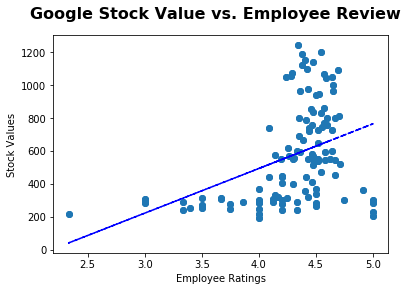

<Figure size 1440x1280 with 0 Axes>

In [22]:
# Plot data
fig, ax = plt.subplots()

fig.suptitle("Google Stock Value vs. Employee Review", fontsize=16, fontweight="bold")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)

ax.set_xlabel("Employee Ratings")
ax.set_ylabel("Stock Values")

ax.plot(x_axis, y_axis, linewidth=0, marker='o')
ax.plot(x_axis, fit, 'b--')
figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
# plt.show()